In [3]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 11.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 11.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 14.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [40]:
def get_avg_throughput(df):
    throughput = df["throughput"][1:].mean()
    return throughput

In [48]:
model = "resnet18"
batch_size = 150
workers = 8
log_path = Path("/home/neni/repos/thesis/logs/")

results = {}

all_gpus = [[0], [0, 1], [0, 1, 2]]

for gpus in all_gpus:

    base_path = f"{model}_b{batch_size}_j{workers}_dev{''.join(map(str,gpus))}"

    workloads = ["", "_dummy", "_dummy_no_memcpy"]

    frames = {}

    for workload in workloads:
        for gpu in gpus:
            path = log_path / Path(base_path + workload + f"_gpu{gpu}.csv")
            #print(path)
            df = pd.read_csv(path, index_col=0)
            wl_name = workload[1:] if workload else "base"
            name = wl_name + "_" + f"gpu_{gpu}"
            frames[name] = get_avg_throughput(df)
    results["".join(map(str,gpus))] = frames

In [101]:
def convert_results(results):
    keys = results.keys()
    new_results = {}

    workloads = ["base_gpu_", "dummy_gpu_", "dummy_no_memcpy_gpu_"]
    names = ["Base", "Dummy\n(memcpy)", "Dummy\n(on device)"]

    for key in keys:
        dev_results = {"name": [], "throughput": []}
        for i, wl in enumerate(workloads):
            sums = []
            for k in [*key]:
                sums.append(results[key][wl+k])
            #dev_results[names[i]] = int(sum(sums) / len(sums))
            dev_results["name"].append(names[i])
            dev_results["throughput"].append(int(sum(sums) / len(sums)))
        new_results[key] = dev_results
    return new_results

In [102]:
final_results = convert_results(results)
final_results

{'0': {'name': ['Base', 'Dummy\n(memcpy)', 'Dummy\n(on device)'],
  'throughput': [253, 289, 510]},
 '01': {'name': ['Base', 'Dummy\n(memcpy)', 'Dummy\n(on device)'],
  'throughput': [380, 413, 581]},
 '012': {'name': ['Base', 'Dummy\n(memcpy)', 'Dummy\n(on device)'],
  'throughput': [429, 528, 587]}}

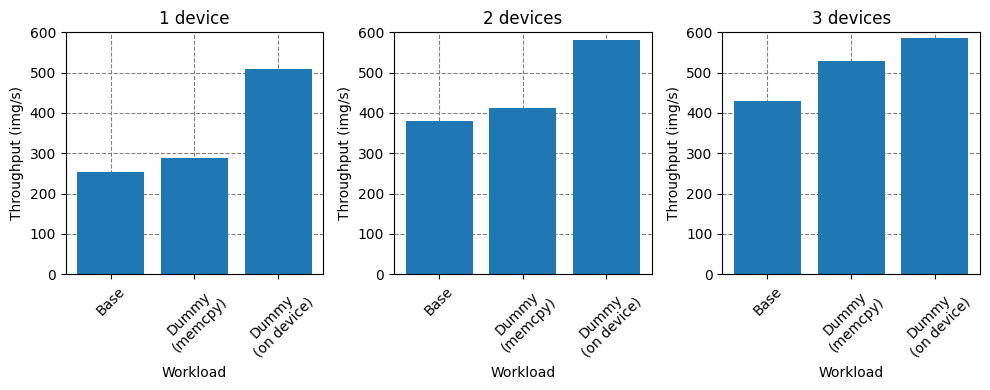

In [109]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
devices = ["0", "01", "012"]
names = ["1 device", "2 devices", "3 devices"]

for i, ax in enumerate([ax1, ax2, ax3]):
    ax.bar(final_results[devices[i]]["name"], final_results[devices[i]]["throughput"])
    ax.set_xlabel('Workload')
    plt.setp(ax.get_xticklabels(), ha="center", rotation=45)
    ax.set_ylabel('Throughput (img/s)')
    ax.set_title(names[i])
    ax.set_ylim(0, 600)
    ax.set_axisbelow(True)
    ax.grid(color='gray', linestyle='dashed')
    

# adjust layout and display subplots
plt.tight_layout()
plt.show()